In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from cbrain.utils import limit_mem

/home/s/S.Rasp/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
limit_mem()

In [3]:
import keras
from keras.layers import *
from keras.models import Model, Sequential

In [27]:
import seaborn as sns
import pandas as pd

## MNIST AE

In [6]:
from keras.datasets import mnist

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
x_train.shape

(60000, 28, 28)

In [10]:
x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)

In [12]:
x_train.shape

(60000, 784)

In [13]:
x_train, x_test = x_train/255, x_test/255

In [30]:
def show_imgs(x):
    fig, axs = plt.subplots(1, 5)
    for i, ax in enumerate(axs.flat):
        ax.imshow(x[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

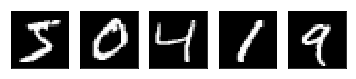

In [31]:
show_imgs(x_train)

In [41]:
inp = Input(shape=(784,))
enc = Dense(10, activation='elu')(inp)
out = Dense(784, activation='sigmoid')(enc)
model = Model(inp, out)

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_10 (Dense)             (None, 784)               8624      
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile('adam', 'binary_crossentropy')

In [44]:
model.fit(x_train, x_train, epochs=30, batch_size=256, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 2s 32us/step - loss: 0.3372 - val_loss: 0.2587
Epoch 2/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.2348 - val_loss: 0.2139
Epoch 3/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.2031 - val_loss: 0.1920
Epoch 4/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.1900 - val_loss: 0.1859
Epoch 5/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.1860 - val_loss: 0.1833
Epoch 6/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.1840 - val_loss: 0.1818
Epoch 7/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.1829 - val_loss: 0.1808
Epoch 8/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.1820 - val_loss: 0.1802
Epoch 9/30
60000/60000 [==============================] - 2s 28us/step - loss: 0.1815 - val_loss: 0.1796
Epoch

In [45]:
preds = model.predict(x_test, 1024)

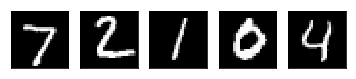

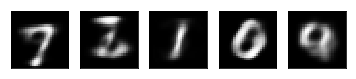

In [46]:
show_imgs(x_test)
show_imgs(preds)

## CBRAIN workflow

In [47]:
from cbrain.data_generator import *

In [48]:
DATADIR = '/local/S.Rasp/preprocessed_data/'

In [63]:
train_fn = 'fbp_engy_ess_train_sample1_shuffle'
valid_fn = 'fbp_engy_ess_valid_sample1'
norm_fn = 'fbp_engy_ess_train_sample1_norm.nc'

In [50]:
bs = 512

In [52]:
trn_gen_obj = DataGenerator(
    DATADIR, train_fn + '_features.nc', train_fn + '_targets.nc', bs, norm_fn,
    fsub='feature_means', fdiv='feature_stds', tmult='target_conv',shuffle=True,
)
trn_gen = trn_gen_obj.return_generator()

Generator will have 23494656 samples in 45888 batches
Features have shape 94; targets have shape 65


In [86]:
val_gen_obj = DataGenerator(
    DATADIR, valid_fn + '_features.nc', valid_fn + '_targets.nc', bs, norm_fn,
    fsub='feature_means', fdiv='feature_stds', tmult='target_conv',shuffle=True,
)
val_gen = trn_gen_obj.return_generator()

Generator will have 23494656 samples in 45888 batches
Features have shape 94; targets have shape 65


In [87]:
true = np.concatenate([next(val_gen)[1] for i in range(20)])

In [53]:
x, y = next(trn_gen)

In [54]:
x.shape, y.shape

((512, 94), (512, 65))

In [56]:
ref_model = Sequential([
    Dense(256, input_shape=(x.shape[1],), activation='elu'),
    Dense(256, activation='elu'),
    Dense(y.shape[1], activation='linear')
])

In [57]:
ref_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               24320     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 65)                16705     
Total params: 106,817
Trainable params: 106,817
Non-trainable params: 0
_________________________________________________________________


In [58]:
ref_model.compile('adam', 'mse')

In [59]:
ref_model.fit_generator(trn_gen, trn_gen_obj.n_batches, epochs=1)

Epoch 1/1
45888/45888 [==============================] - 267s 6ms/step - loss: 0.0061


In [66]:
ref_model.evaluate_generator(val_gen, 20)

0.005579440575093031

In [83]:
preds = ref_model.predict_generator(val_gen, 20)

In [84]:
preds.shape

(10240, 65)

In [213]:
def show_cbrain(x_true, x_pred, random=True):
    fig, axs = plt.subplots(1, 5, figsize=(10, 5))
    for i, ax in enumerate(axs.flat):
        i = np.random.randint(0, len(x_pred)) if random else i
        ax.plot(x_true[i], label='true')
        ax.plot(x_pred[i], label='pred')
    axs[-1].legend()
    plt.tight_layout(); plt.show()

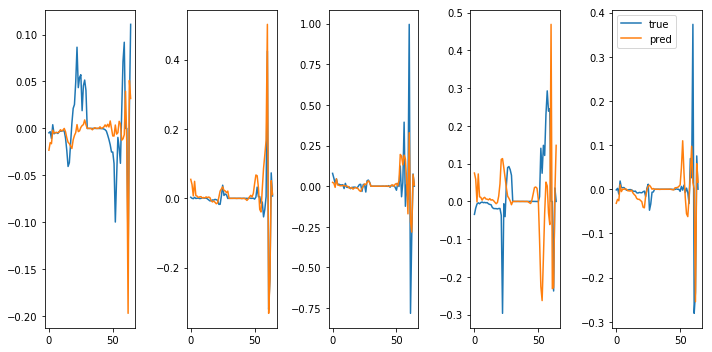

In [207]:
show_cbrain(true, preds)

## CBRAIN AE

In [93]:
model = Sequential([
    Dense(256, input_shape=(x.shape[1],), activation='elu'),
    Dense(10, activation='elu'),
    Dense(256, activation='elu'),
    Dense(y.shape[1], activation='linear')
])

In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               24320     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               2816      
_________________________________________________________________
dense_18 (Dense)             (None, 65)                16705     
Total params: 46,411
Trainable params: 46,411
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.compile('adam', 'mse')

In [96]:
model.fit_generator(trn_gen, trn_gen_obj.n_batches, epochs=1)

Epoch 1/1
45888/45888 [==============================] - 258s 6ms/step - loss: 0.0061


In [97]:
model.evaluate_generator(val_gen, 20)

0.0057174216490238905

In [98]:
preds2 = ref_model.predict_generator(val_gen, 20)

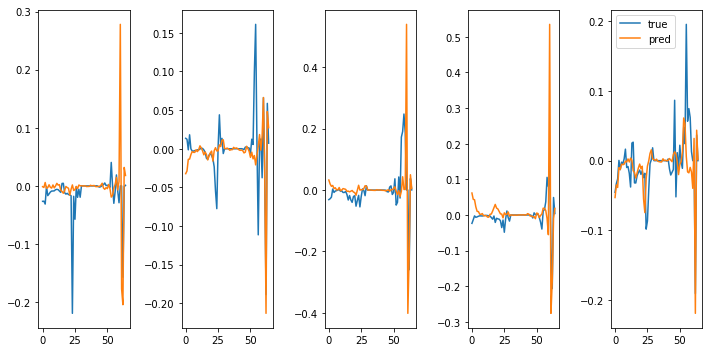

In [99]:
show_cbrain(true, preds2)

## VAE MNIST

In [112]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [114]:
latent_dim = 10
inputs = Input(shape=(784,))
x = Dense(256, activation='elu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')



latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(256, activation='elu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')


outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [115]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 256)          200960      input_12[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           2570        dense_29[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 10)           2570        dense_29[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [116]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  206100    
_________________________________________________________________
decoder (Model)              (None, 784)               204304    
Total params: 410,404
Trainable params: 410,404
Non-trainable params: 0
_________________________________________________________________


In [117]:
from keras.losses import mse, binary_crossentropy

In [119]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  


In [121]:
vae.fit(x_train, epochs=30, batch_size=256, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 2s 40us/step - loss: 196.0094 - val_loss: 149.0853
Epoch 2/30
60000/60000 [==============================] - 2s 31us/step - loss: 145.1804 - val_loss: 140.8794
Epoch 3/30
60000/60000 [==============================] - 2s 31us/step - loss: 139.9110 - val_loss: 136.3278
Epoch 4/30
60000/60000 [==============================] - 2s 31us/step - loss: 135.5412 - val_loss: 132.2584
Epoch 5/30
60000/60000 [==============================] - 2s 31us/step - loss: 131.5816 - val_loss: 128.4293
Epoch 6/30
60000/60000 [==============================] - 2s 31us/step - loss: 128.2096 - val_loss: 125.4951
Epoch 7/30
60000/60000 [==============================] - 2s 31us/step - loss: 125.4682 - val_loss: 123.2077
Epoch 8/30
60000/60000 [==============================] - 2s 31us/step - loss: 123.2903 - val_loss: 121.2391
Epoch 9/30
60000/60000 [==============================] - 2s 31us/step - loss:

In [124]:
preds = vae.predict(x_test, 1024)
preds2 = vae.predict(x_test, 1024)

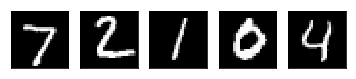

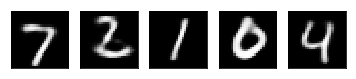

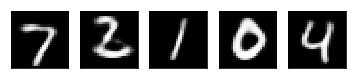

In [127]:
show_imgs(x_test)
show_imgs(preds)
show_imgs(preds2)

## VAE CBRAIN

In [129]:
x, y = next(trn_gen)
x.shape, y.shape

((512, 94), (512, 65))

In [185]:
latent_dim = 16
inputs = Input(shape=(94,))
x = Dense(256, activation='elu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')



latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(256, activation='elu')(latent_inputs)
outputs = Dense(65, activation='linear')(x)
decoder = Model(latent_inputs, outputs, name='decoder')


outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [186]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 94)           0                                            
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 256)          24320       input_19[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           4112        dense_50[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           4112        dense_50[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [187]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 16)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               4352      
_________________________________________________________________
dense_52 (Dense)             (None, 65)                16705     
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________


In [188]:
def vae_loss(y_true, y_pred):
    xent_loss = mse(y_true, y_pred)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + 0.001 * kl_loss

In [182]:
vae.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [189]:
vae.compile(optimizer='adam', loss=vae_loss, metrics=['mse'])

In [198]:
vae.fit_generator(trn_gen, trn_gen_obj.n_batches, epochs=1)

Epoch 1/1
45888/45888 [==============================] - 390s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0062


In [199]:
vae.evaluate_generator(val_gen, 20)

[0.006604569894261658, 0.00618019534740597]

In [216]:
preds = vae.predict_generator(val_gen, 20)


In [217]:
preds2 = vae.predict_generator(val_gen, 20)

In [ ]:
inp = next(val_gen)

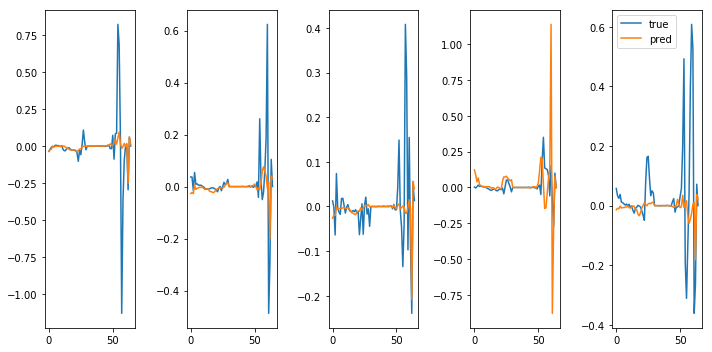

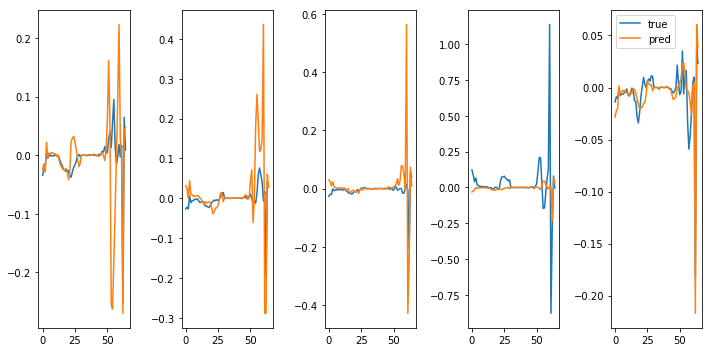

In [218]:
show_cbrain(true, preds, False)
show_cbrain(preds, preds2, False)

## Check trained VAE

In [6]:
from keras.utils.generic_utils import get_custom_objects
from keras.losses import mse

In [7]:
get_custom_objects().update({"vae_loss": mse, 'z_kl_loss': mse})

In [8]:
from cbrain.model_diagnostics import *
def get_stats(model_name, pref, norms=(None, None, None, None), trn_val='valid', compute_stats=True,
              sample='sample1', convo=False, convo_tile=False):
    model_path = model_dir + model_name + '.h5'
    diag = ModelDiagnostics(model_path, 
                    fpath=f'{pre_dir}{pref}_{trn_val}_{sample}_features.nc',
                    tpath=f'{pre_dir}{pref}_{trn_val}_{sample}_targets.nc',
                    npath=f'{pre_dir}{pref}_train_{sample}_norm.nc',
                    norms=norms, convo=convo, convo_tile=convo_tile)
    if compute_stats:
        diag.compute_stats()
        print(diag.mean_stats(9))
    return diag

In [9]:
# LMU
model_dir = '/home/s/S.Rasp/repositories/CBRAIN-CAM/saved_models/'
pre_dir = '/local/S.Rasp/preprocessed_data/'

In [10]:
norms = ('feature_means', 'max_rs', None, 'target_conv')

In [119]:
ds = {}

In [120]:
ds['VAE01_ref'] = ModelDiagnostics(
    model_path=f'{model_dir}VAE01_ref.h5', 
    fpath=f'{pre_dir}fbp_engy_ess_valid_sample1_features.nc',
    tpath=f'{pre_dir}fbp_engy_ess_valid_sample1_targets.nc',
    npath=f'{pre_dir}fbp_engy_ess_train_sample1_norm.nc',
    norms=norms)
ds['VAE03_vae'] = ModelDiagnostics(
    model_path=f'{model_dir}VAE03_vae.h5', 
    fpath=f'{pre_dir}fbp_engy_ess_valid_sample1_features.nc',
    tpath=f'{pre_dir}fbp_engy_ess_valid_sample1_targets.nc',
    npath=f'{pre_dir}fbp_engy_ess_train_sample1_norm.nc',
    norms=norms)
ds['VAE04_vae_beta'] = ModelDiagnostics(
    model_path=f'{model_dir}VAE04_vae_beta.h5', 
    fpath=f'{pre_dir}fbp_engy_ess_valid_sample1_features.nc',
    tpath=f'{pre_dir}fbp_engy_ess_valid_sample1_targets.nc',
    npath=f'{pre_dir}fbp_engy_ess_train_sample1_norm.nc',
    norms=norms)
ds['VAE05_vae_beta2'] = ModelDiagnostics(
    model_path=f'{model_dir}VAE05_vae_beta2.h5', 
    fpath=f'{pre_dir}fbp_engy_ess_valid_sample1_features.nc',
    tpath=f'{pre_dir}fbp_engy_ess_valid_sample1_targets.nc',
    npath=f'{pre_dir}fbp_engy_ess_train_sample1_norm.nc',
    norms=norms)

In [121]:
for d in ds.values():
    d.compute_stats()

100%|██████████| 2868/2868 [00:55<00:00, 51.49it/s]
/home/s/S.Rasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:259: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/home/s/S.Rasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:265: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])
100%|██████████| 2868/2868 [00:49<00:00, 57.79it/s]


In [138]:
ds['VAE06_vae_beta_wide'] = ModelDiagnostics(
    model_path=f'{model_dir}VAE06_vae_beta_wide.h5', 
    fpath=f'{pre_dir}fbp_engy_ess_valid_sample1_features.nc',
    tpath=f'{pre_dir}fbp_engy_ess_valid_sample1_targets.nc',
    npath=f'{pre_dir}fbp_engy_ess_train_sample1_norm.nc',
    norms=norms)

In [122]:
for k, d in ds.items():
    print(k)
    print(d.mean_stats(9))

VAE01_ref
                 bias          mse    pred_mean    true_mean  pred_sqmean  \
TPHYSTND  2.93939e-08  1.36669e-09  1.16117e-07   8.6723e-08  1.75975e-09   
PHQ      -3.12337e-13  1.69739e-15  1.07145e-09  1.07176e-09  7.92835e-16   
FSNT        0.0423055      779.139       230.94      230.898       158600   
FSNS        0.0474433      951.213      163.904      163.856      88703.2   
FLNT        -0.279687      167.749      222.279      222.559        51392   
FLNS        -0.011864      94.0112      52.3025      52.3144      3411.18   
PRECT     4.93933e-11  1.40394e-15  3.12454e-08   3.1196e-08  1.17799e-14   
all               NaN          NaN          NaN          NaN          NaN   

          true_sqmean     pred_var     true_var        r2  hor_tsqmean  \
TPHYSTND  3.10989e-09  1.61116e-09  2.96076e-09  0.411029  3.10989e-09   
PHQ       2.47724e-15  7.37745e-16  2.42256e-15  -9.92082  2.47724e-15   
FSNT           159345      83523.2      84282.4      -inf       159345   


In [139]:
ps1 = np.array([[ds['VAE04_vae_beta'].get_pt(t, 'TPHYSTND')[0] for i in range(20)] for t in range(10)])
ps2 = np.array([[ds['VAE06_vae_beta_wide'].get_pt(t, 'TPHYSTND')[0] for i in range(20)] for t in range(10)])
ts1 = np.array([ds['VAE04_vae_beta'].get_pt(t, 'TPHYSTND')[1] for t in range(10)])

In [140]:
[-1] + list(ps.shape[-3:])

[-1, 12800, 15]

In [141]:
ilat = 31

In [142]:
ps_ref = ps2.reshape([-1] + list(ps2.shape[-2:]))[:, ilat, 15:]
ps = ps1.reshape([-1] + list(ps1.shape[-2:]))[:, ilat, 15:]
ts = ts1.reshape([-1] + list(ts1.shape[-2:]))[:, ilat, 15:]

In [143]:
ps.shape, ts.shape

((12800, 15), (640, 15))

In [144]:
df = pd.DataFrame(data=ps)
df2 = pd.DataFrame(data=ts)
df_ref = pd.DataFrame(data=ps_ref)

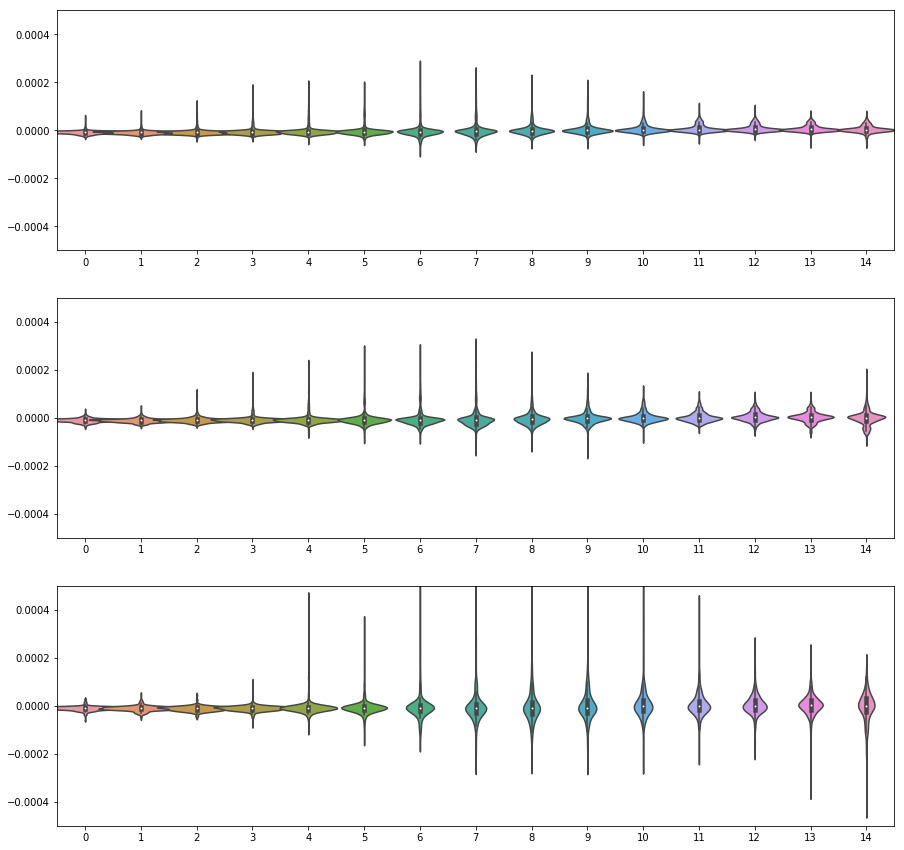

In [145]:
fig, axs = plt.subplots(3,1, figsize=(15, 15))
sns.violinplot(data=df, ax=axs[0], width=2)
sns.violinplot(data=df2, ax=axs[2], width=2)
sns.violinplot(data=df_ref, ax=axs[1], width=2)
for ax in axs: ax.set_ylim(-0.0005, 0.0005)

In [150]:
ps1.shape

(10, 20, 64, 128, 30)

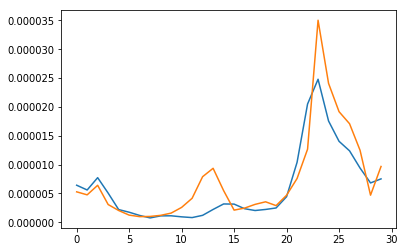

In [154]:
plt.plot(ps1[:, :, 32, 0].std((0, 1)))
plt.plot(ps2[:, :, 32, 0].std((0, 1)))

In [57]:
def plot_violin(d, var, itime, ilat, ilon, min_lev):
    p, t = d.get_pt(itime, var)
    ps = np.array([d.get_pt(itime, var)[0] for i in range(200)])
    df = pd.DataFrame(data=ps[:, ilat, ilon, min_lev:])
    fig = plt.figure(figsize=(15, 10))
    ax = sns.violinplot(data=df)#, x="groups", y="vals")
    ax.plot(t[ilat, ilon, min_lev:], c='b')
    for i in range(5):
        ax.plot(ps[i, ilat, ilon, min_lev:])

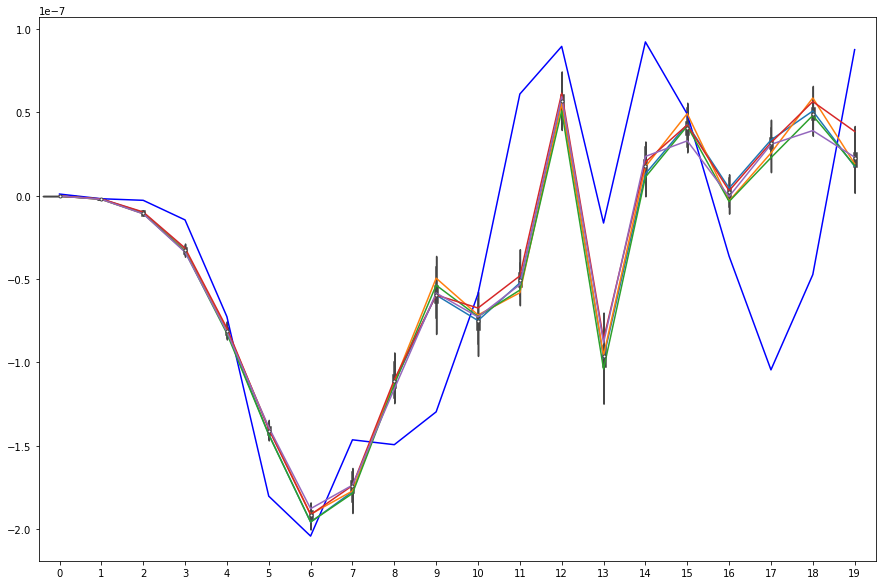

In [161]:
plot_violin(ds['VAE06_vae_beta_wide'], 'PHQ', 10, 31, 100, 10)

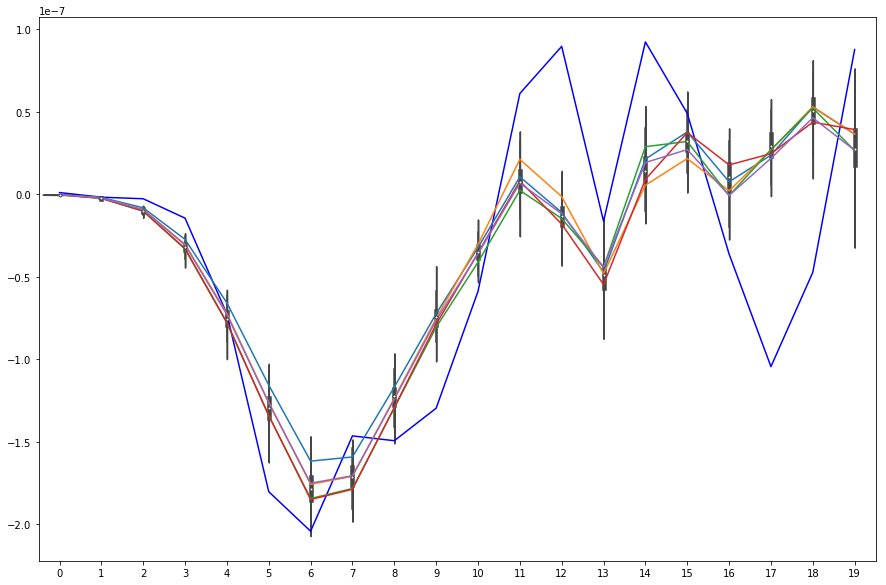

In [162]:
plot_violin(ds['VAE04_vae_beta'], 'PHQ', 10, 31, 100, 10)

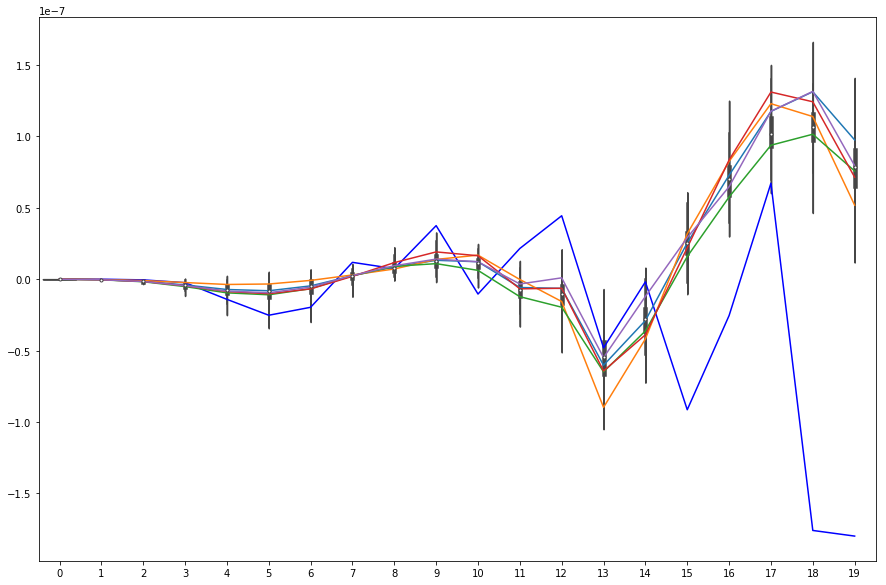

In [63]:
plot_violin(ds['VAE04_vae_beta'], 'PHQ', 10, 40, 100, 10)

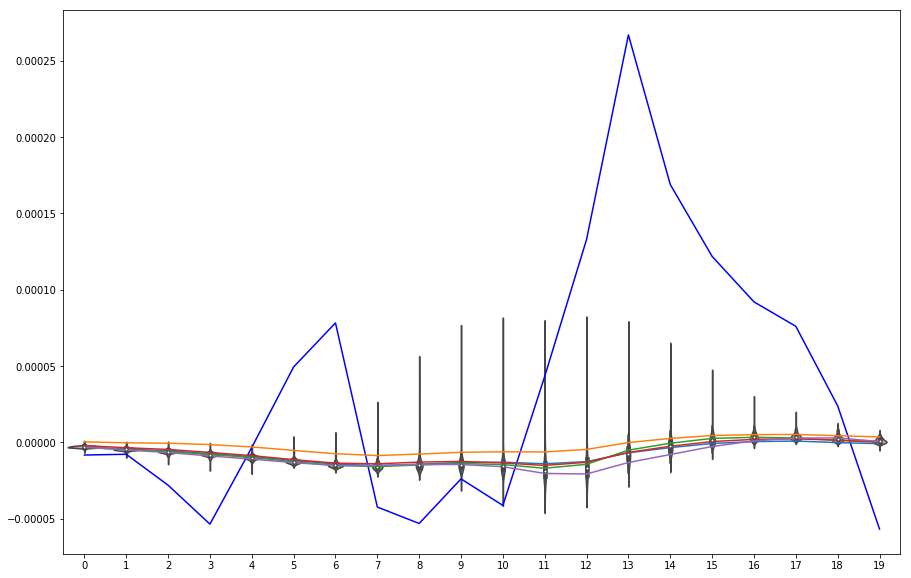

In [62]:
plot_violin(ds['VAE05_vae_beta2'], 'TPHYSTND', 10, 40, 100, 10)

In [16]:
p, t = d4.get_pt(10, 'PRECT')

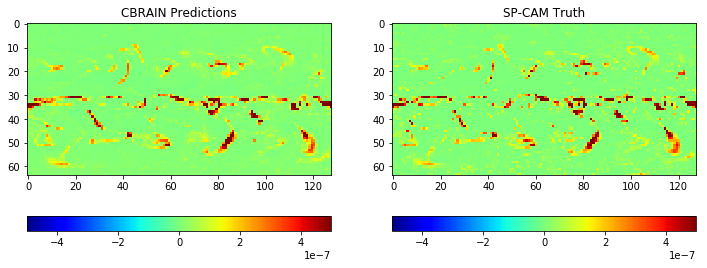

In [22]:
d4.plot_double_xy(10, 0, 'PRECT', cmap='jet', vmin=-5e-7, vmax=5e-7);

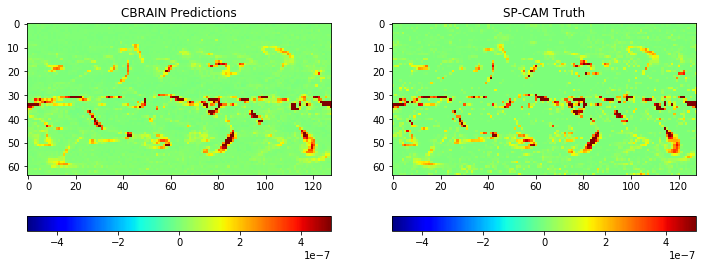

In [23]:
d4.plot_double_xy(10, 0, 'PRECT', cmap='jet', vmin=-5e-7, vmax=5e-7);

In [24]:
ps = np.array([d4.get_pt(10, 'TPHYSTND')[0] for i in range(200)])

(array([ 9., 10., 21., 43., 26., 31., 25., 22.,  7.,  6.]),
 array([-3.70309972e-05, -3.25983511e-05, -2.81657050e-05, -2.37330588e-05,
        -1.93004127e-05, -1.48677666e-05, -1.04351205e-05, -6.00247436e-06,
        -1.56982824e-06,  2.86281788e-06,  7.29546400e-06]),
 <a list of 10 Patch objects>)

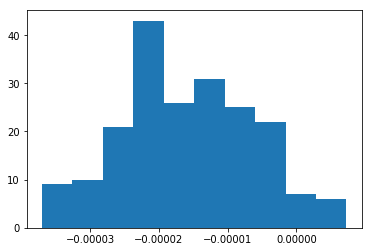

In [25]:
plt.hist(ps[:, 40, 0, 23])

(array([13., 79., 70., 20., 11.,  4.,  1.,  0.,  0.,  2.]),
 array([-1.44822661e-05, -6.74595394e-06,  9.90358240e-07,  8.72667042e-06,
         1.64629826e-05,  2.41992948e-05,  3.19356070e-05,  3.96719191e-05,
         4.74082313e-05,  5.51445435e-05,  6.28808557e-05]),
 <a list of 10 Patch objects>)

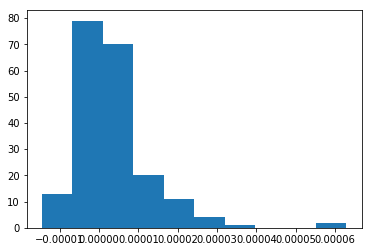

In [26]:
plt.hist(ps[:, 10, 0, 23])

In [35]:
p, t = d4.get_pt(10, 'TPHYSTND')

In [36]:
t.shape

(64, 128, 30)

In [32]:
df = pd.DataFrame(data=ps[:, 40, 0, 10:])

In [33]:
#df = df.melt(var_name='groups', value_name='vals')

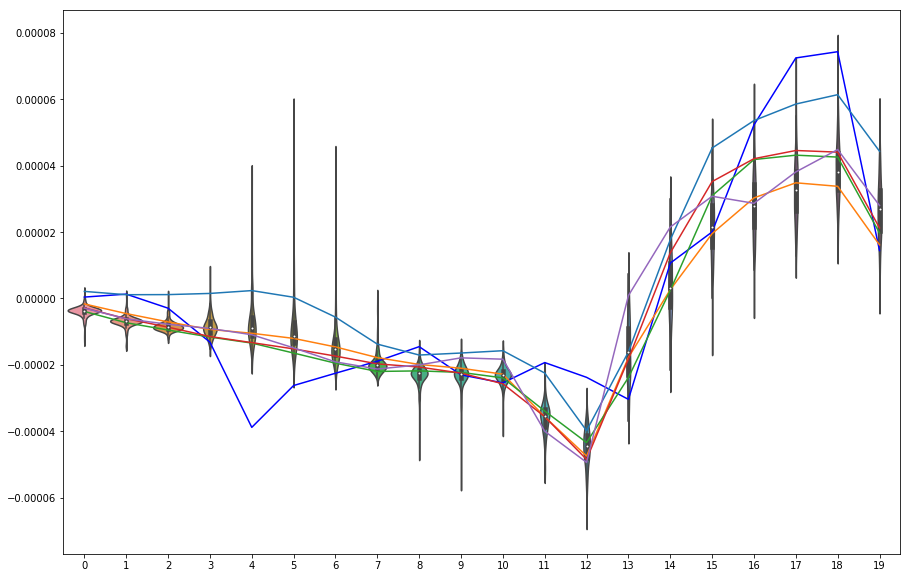

In [40]:
fig = plt.figure(figsize=(15, 10))
ax = sns.violinplot(data=df)#, x="groups", y="vals")
ax.plot(t[40, 0, 10:], c='b')
for i in range(5):
    ax.plot(ps[i, 40, 0, 10:])

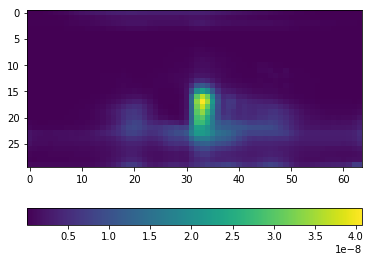

In [42]:
d4.plot_slice(d4.stats['true_var'][:, :, d4._get_var_idxs('TPHYSTND')].mean(1).T);

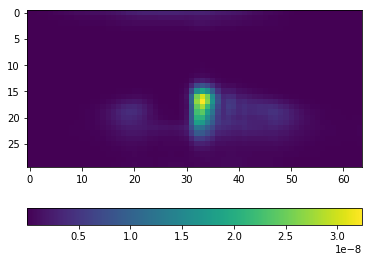

In [43]:
d4.plot_slice(d4.stats['pred_var'][:, :, d4._get_var_idxs('TPHYSTND')].mean(1).T);

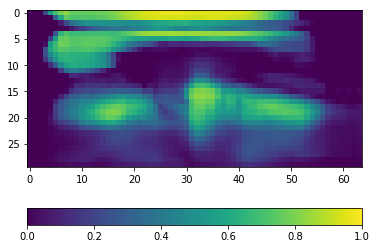

In [46]:
d4.plot_slice(d4.stats['r2'][:, :, d4._get_var_idxs('TPHYSTND')].mean(1).T, vmin=0, vmax=1);